In [1]:
import numpy as np
import random

### Set up plotting

In [2]:
import math
from matplotlib import pyplot as plt

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, sub_titles=None, grayscale=False, cmap=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        if sub_titles is not None:
            sp.set_title(str(titles[i]) + " (" + str(sub_titles[i]) + ")", fontsize=14)
        plt.imshow(ims[i].reshape((28,28)), interpolation=None if interp else 'none', cmap=cmap)

In [3]:
%matplotlib inline

### Load images

In [4]:
from keras import backend as K
from keras.datasets import mnist as mnist_dataset

class MNISTImages:
    def __init__(self):
        img_rows = img_cols = 28
        
        (X_train, y_train), (X_test, y_test) = mnist_dataset.load_data()

        if K.image_dim_ordering() == 'th':
            X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
            X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
            X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train = X_train/128 - 1
        X_test = X_test/128 - 1
            
        self.train_input = X_train
        self.train_labels = self.to_categorical(y_train)
        
        self.test_input = X_test
        self.test_labels = self.to_categorical(y_test)
        
    def to_categorical(self,y):
        y = np.array(y, dtype='int').ravel()
        nb_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, nb_classes))
        categorical[np.arange(n), y] = 1
        return categorical
    
mnist = MNISTImages()

Using TensorFlow backend.


11476992/11490434 [============================>.] - ETA: 0s

### Set up networks

In [5]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D

gen_mul = 20

g_input = Input(shape=(100,))
g = Dense(14*14*gen_mul*4, input_shape=(100,), kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = LeakyReLU(0.2)(g)
g = Reshape( [14, 14, gen_mul*4] )(g)
g = Conv2D(gen_mul*2, (4, 4), padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = LeakyReLU(0.2)(g)
#g = Conv2DTranspose(gen_mul, (5, 5),padding="same", strides=(2, 2))(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul, (4, 4), padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = LeakyReLU(0.2)(g)
g_output = Conv2D(1, (4, 4), activation="tanh", padding="same", kernel_initializer='glorot_uniform')(g)

disc_mul = 80

d_input = Input(shape=(28,28,1))
d = BatchNormalization(axis=3)(d_input)
d = Conv2D(disc_mul*2, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*2, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = BatchNormalization(axis=3)(d)
d = Dropout(0.1)(d)
d = Conv2D(disc_mul, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = Dropout(0.2)(d)
d = Flatten()(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.45)(d)
d = Dense(1)(d)
d_output = Activation('sigmoid')(d)


opt = Nadam(lr=1e-3)
dopt = Nadam(lr=1e-3)

generator = Model(g_input,g_output)
generator.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

discriminator = Model(d_input,d_output)
discriminator.compile(optimizer=dopt, loss='binary_crossentropy', metrics=['accuracy'])

gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
GAN = Model(gan_input, gan_output)
GAN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

### Let's see what the generator does by default

In [6]:
def get_random_input_for_generator(n):
    return np.random.normal(0, 1, (n,100))

In [7]:
def get_generator_samples(n=8):
    plots(generator.predict(get_random_input_for_generator(n)), cmap='gray', rows=math.ceil(n/4))

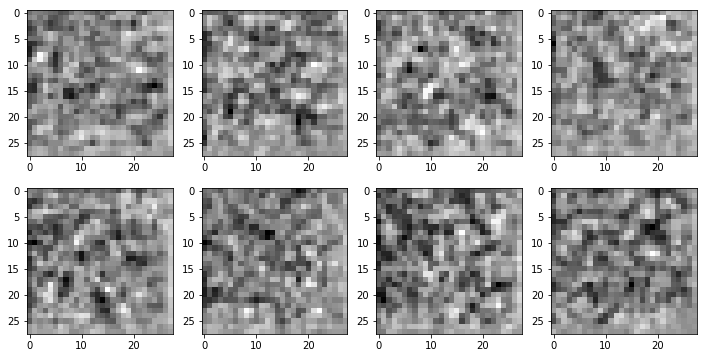

In [8]:
get_generator_samples()

### Train gan

In [9]:
fake_image_history = []

In [15]:
from IPython import display

def plot_loss(losses):
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.yscale('log')
        plt.plot(losses["dr"], label='discriminitive loss on real')
        plt.plot(losses["dg"], label='discriminitive loss on generated')
        plt.plot(losses["dgo"], label='discriminitive loss on old generated')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

        
def train_discriminator(batch_size, i=10000):
    fake_images = np.array(generator.predict(get_random_input_for_generator(batch_size*4)))
    real_images = mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=batch_size),:,:,:]
    
    fake_image_history.append(fake_images[np.random.randint(0,batch_size)])
    
    old_fake_images = np.array([fake_image_history[np.random.randint(0,len(fake_image_history))] for i in range(batch_size)])
    
    make_trainable(discriminator,True)
    
    noise_level = pow(0.5, 1+i/1500)
    
    #dr_loss = discriminator.train_on_batch(real_images, np.random.uniform(1 - noise_level, 1, batch_size))
    #dg_loss = discriminator.train_on_batch(fake_images, np.random.uniform(0, noise_level, batch_size*4))
    #dgo_loss = discriminator.train_on_batch(old_fake_images, np.random.uniform(0, noise_level, batch_size))
    
    dr_loss = discriminator.train_on_batch(real_images, np.ones(batch_size))
    dg_loss = discriminator.train_on_batch(fake_images, np.zeros(batch_size*4))
    dgo_loss = discriminator.train_on_batch(old_fake_images, np.zeros(batch_size))
    
    return dr_loss, dg_loss, dgo_loss
        
def train_generator(batch_size):
    prior_x = np.array(get_random_input_for_generator(2*batch_size))
    prior_labels = np.array([1]*(2*batch_size))

    make_trainable(discriminator,False)
    return GAN.train_on_batch(prior_x, prior_labels)
        
def train_gan(epochs=5000, batch_size=32):
    losses = {"dr":[], "dg":[], "dgo": [], "g":[]}
    preview_inputs = get_random_input_for_generator(4)
        
    for i in range(epochs):
        dr_loss, dg_loss, dgo_loss = train_discriminator(batch_size, i)
        g_loss = train_generator(batch_size)
        
        losses['dr'].append(dr_loss[0])
        losses['dg'].append(dg_loss[0])
        losses['dgo'].append(dgo_loss[0])
        losses['g'].append(g_loss[0])
        
        if i%100 == 0:
            display.clear_output(wait=True)
            plots(generator.predict(preview_inputs), cmap='gray', rows=1)
            plot_loss(losses)
            print(i, dr_loss[0], dg_loss[0], dgo_loss[0], g_loss[0],  dr_loss[1], dg_loss[1], g_loss[1], dgo_loss[1])
        
        
        

In [13]:
for i in range(300):
    dr_loss, dg_loss, dgo_loss = train_discriminator(32)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, dr_loss[0], dg_loss[0], dgo_loss[0], dr_loss[1], dg_loss[1], dgo_loss[1])

295 0.0204838 0.0171934 0.0203366 0.0 0.0 0.0


In [74]:
for i in range(500):
    g_loss = train_generator(32)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, g_loss[0], g_loss[1])

495 4.17235e-07 1.0


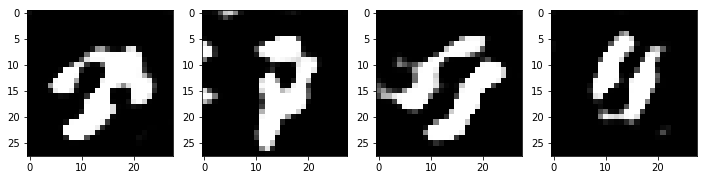

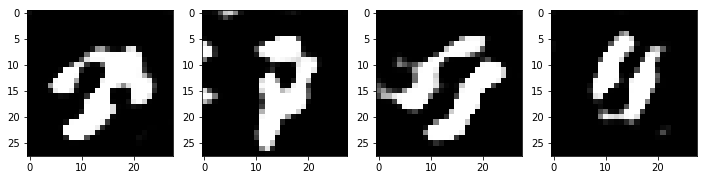

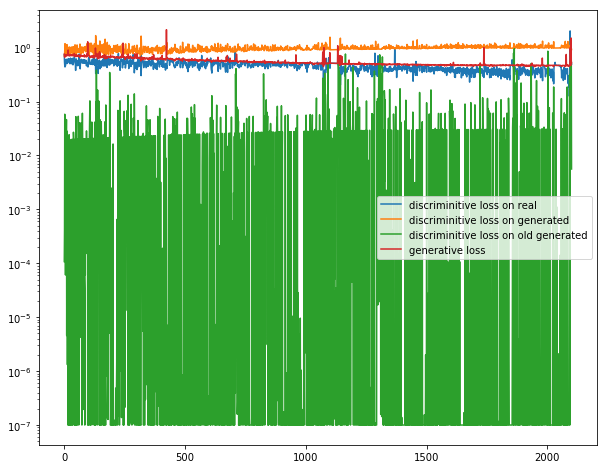

2100 0.490445 0.929649 0.00559667 0.51822 0.96875 0.078125 0.9375 1.0


KeyboardInterrupt: 

In [30]:
train_gan(epochs=5000, batch_size=32)

In [ ]:
get_generator_samples()

In [29]:
opt.lr = 1e-6
dopt.lr = opt.lr

In [ ]:
train_gan(epochs=500)

In [ ]:
GAN.predict(get_random_input_for_generator(8))

In [ ]:
discriminator.predict(mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=8),:,:,:])

In [ ]:
make_trainable(discriminator,True)
discriminator.summary()

In [ ]:
generator.summary()

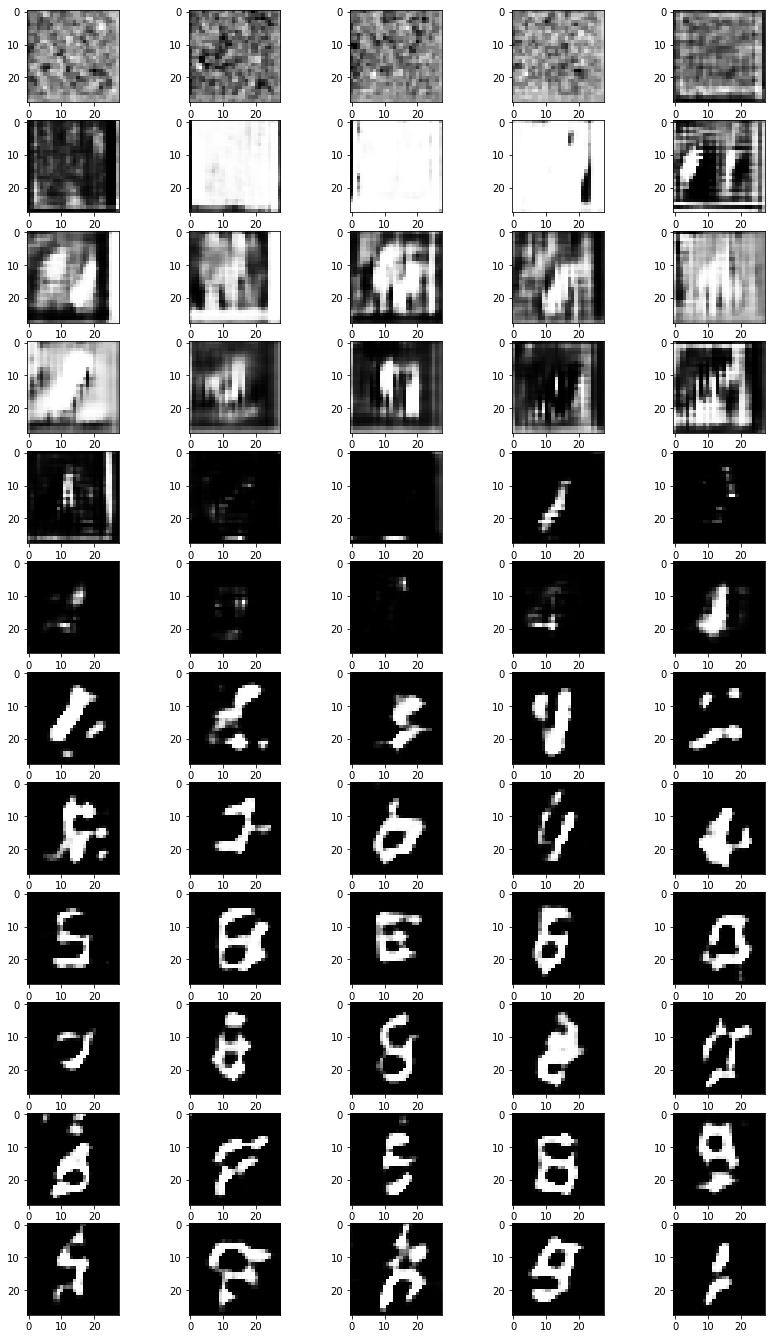

In [31]:
plots([fake_image_history[i*math.floor(len(fake_image_history)/60)] for i in range(60)], figsize=(14,24), cmap='gray', rows=12)

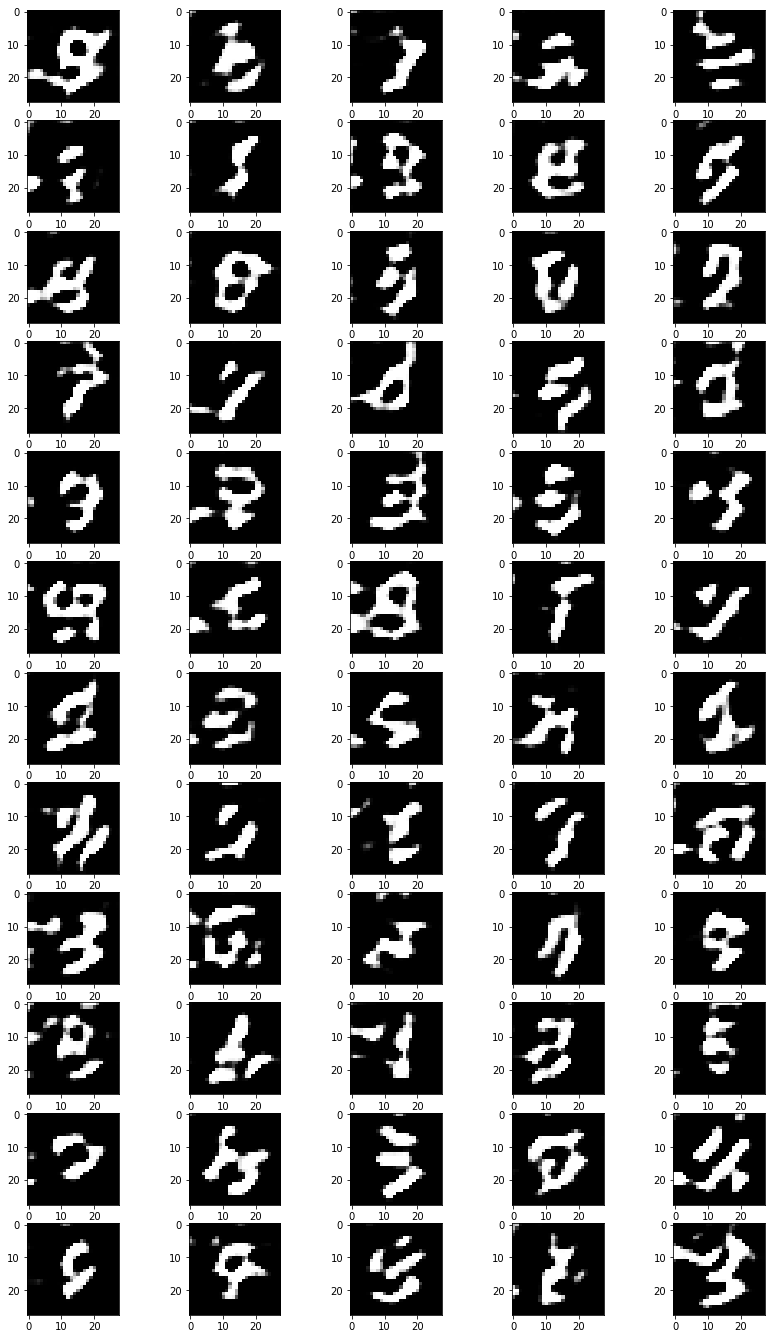

In [32]:
plots(generator.predict(get_random_input_for_generator(60)), figsize=(14,24), cmap='gray', rows=12)

In [28]:
generator.save_weights('/data/trained_models/mnist/gan/generator_v1.h5')
discriminator.save_weights('/data/trained_models/mnist/gan/discriminator_v1.h5')